# AUGMENTING THE IMAGES TO SIMULATE REAL LIFE EXAMPLES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import random
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms, models
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageEnhance, ImageFilter
from scipy.ndimage.interpolation import zoom

In [ ]:
path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks')
os.chdir(path)
print(path)

/content/drive/MyDrive/Colab Notebooks


In [ ]:
BASE_PATH = 'jpeg'
print(BASE_PATH)

jpeg


### Load the dataset

In [ ]:
train_df = pd.read_csv(os.path.join(path,"train_sample.csv"))
train_df.head()

,index,image_name,benign_malignant,target,images
0,23431,ISIC_7122402,benign,0,jpeg/train/ISIC_7122402.jpg
1,13596,ISIC_4170698,malignant,1,jpeg/train/ISIC_4170698.jpg
2,25592,ISIC_7765038,benign,0,jpeg/train/ISIC_7765038.jpg
3,23708,ISIC_7196094,benign,0,jpeg/train/ISIC_7196094.jpg
4,31532,ISIC_9528732,benign,0,jpeg/train/ISIC_9528732.jpg


In [ ]:
test = pd.read_csv(os.path.join(path,"test_sample.csv"))
test.head()

,index,image_name,benign_malignant,target,images
0,12917,ISIC_3975660,benign,0,jpeg/train/ISIC_3975660.jpg
1,31076,ISIC_9390275,benign,0,jpeg/train/ISIC_9390275.jpg
2,24601,ISIC_7466678,malignant,1,jpeg/train/ISIC_7466678.jpg
3,22916,ISIC_6966001,malignant,1,jpeg/train/ISIC_6966001.jpg
4,12676,ISIC_3906195,benign,0,jpeg/train/ISIC_3906195.jpg


In [ ]:
df = pd.concat([train_df,test], ignore_index=True)
df = df[['image_name','benign_malignant','target','images']]
df.shape

(11487, 4)

In [ ]:
df.head()

,image_name,benign_malignant,target,images
0,ISIC_7122402,benign,0,jpeg/train/ISIC_7122402.jpg
1,ISIC_4170698,malignant,1,jpeg/train/ISIC_4170698.jpg
2,ISIC_7765038,benign,0,jpeg/train/ISIC_7765038.jpg
3,ISIC_7196094,benign,0,jpeg/train/ISIC_7196094.jpg
4,ISIC_9528732,benign,0,jpeg/train/ISIC_9528732.jpg


In [ ]:
print("The number of rows and columne in train.csv: {}".format(df.shape))
print(df.columns)
print("\nDATA TYPES\n")
print(df.dtypes)
print("\n=================================================\n")
print("\nCOLUMN COUNT\n")
print(df.count())
print("\nNULL COUNT\n")
print(df.isnull().sum())
# df.dropna(axis=0, inplace=True)

The number of rows and columne in train.csv: (11487, 4)
Index(['image_name', 'benign_malignant', 'target', 'images'], dtype='object')

DATA TYPES

image_name          object
benign_malignant    object
target               int64
images              object
dtype: object



COLUMN COUNT

image_name          11487
benign_malignant    11487
target              11487
images              11487
dtype: int64

NULL COUNT

image_name          0
benign_malignant    0
target              0
images              0
dtype: int64


In [ ]:
# Passed a dictionary to astype() function
df = df.astype({ 'benign_malignant':'category','target':'category'})

After preprocessing

In [ ]:
print("The number of rows and columne in train.csv: {}".format(df.shape))

The number of rows and columne in train.csv: (11487, 4)


### Malignant data
This will enable sample of both malignant and benign equally

In [ ]:
malignant_df = df[df['target'] == 1]
malignant_df.head()

,image_name,benign_malignant,target,images
1,ISIC_4170698,malignant,1,jpeg/train/ISIC_4170698.jpg
6,ISIC_7205745,malignant,1,jpeg/train/ISIC_7205745.jpg
7,ISIC_4425657,malignant,1,jpeg/train/ISIC_4425657.jpg
9,ISIC_6496370,malignant,1,jpeg/train/ISIC_6496370.jpg
11,ISIC_1200192,malignant,1,jpeg/train/ISIC_1200192.jpg


### Benign data
This will allow sample of benign seperately

In [ ]:
benign_df = df[df['target'] == 0]
benign_df.head()

,image_name,benign_malignant,target,images
0,ISIC_7122402,benign,0,jpeg/train/ISIC_7122402.jpg
2,ISIC_7765038,benign,0,jpeg/train/ISIC_7765038.jpg
3,ISIC_7196094,benign,0,jpeg/train/ISIC_7196094.jpg
4,ISIC_9528732,benign,0,jpeg/train/ISIC_9528732.jpg
5,ISIC_5367506,benign,0,jpeg/train/ISIC_5367506.jpg


In [ ]:
SEED = 12321
# Seed everything
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

### Helper functions

In [ ]:
def plot_histogram(data, plot_properties):
  """ Generic function to plot a histogram.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.hist(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()


def plot_box(data, plot_properties):
  """ Generic function to plot a box plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":""}
  """
  plt.figure(figsize=(10, 6))
  plt.boxplot(data)
  plt.grid(False)
  plt.title(plot_properties["title"])
  plt.xlabel(plot_properties["xlabel"])
  plt.ylabel(plot_properties["ylabel"])
  plt.show()
    
def plot_count(data,plot_properties):
    """ Generic for a count plot.
      param: data- is an 1D array of data
      param: plot_properties- a dictionary of properties like:
      {"title":"","xlabel":"","ylabel":"", "x":""}
    """
    plt.figure(figsize=(10, 6))
    chart = sns.countplot(data,x=plot_properties['x'],palette='Set2')
    chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=45, horizontalalignment='right')
    plt.title(plot_properties["title"])
    plt.xlabel(plot_properties["xlabel"])
    plt.ylabel(plot_properties["ylabel"])
    plt.show()

def exploring_new_dataset(dataset):
  """ This function performs the role of
      displaying the common information about a dataset
  """
  print("Sample length",len(dataset))
  print(dataset.groupby('benign_malignant').image_name.count())
  plot_count(dataset.benign_malignant, 
               {"title":"IMAGES BY GROUND TRUTH",
                "xlabel":"BENIGN_MALIGNANT","ylabel":"NUMBER OF IMAGES","x":"benign_malignant"})

In [ ]:
def get_sample_from_df(sample,n):
    for i in list(range(1,n+1)): 
        if sample.size>=i: 
            return sample.sample(n=i, random_state=SEED).index[0]
        return [];


def sample_by_patient(dataset,num_sample=1):
  """ Get patient id as category
   Prepare two datasets:
   for each patient_id
       select get records
         if malignant
           sample num_sample
         elif benign
           sample num_sample"""
  unique_patient_id = dataset.patient_id.cat.categories
  malignant_df = dataset[dataset['target'] == 1]

  benign_df = dataset[dataset['target'] == 0]
  sample_indices = []
  #samples per patient
  for  patient_id in unique_patient_id:
      patient_sample = malignant_df[malignant_df['patient_id']==patient_id]
      if patient_sample.size:
          sample_indices.append(get_sample_from_df(patient_sample,num_sample))
      else:
          patient_sample = benign_df[benign_df['patient_id']==patient_id]
          sample_indices.append(get_sample_from_df(patient_sample,num_sample))

  return dataset.loc[sample_indices]

def perform_sampling(dataset,sampling_type="", patient_group_sample=1):
  """function to perform sampling based on
     the sampling type provided.
     Return train, test dataset
  """
  train = None
  test = None
  if sampling_type=="PATIENT_GROUP":
    sample=sample_by_patient(dataset,patient_group_sample)
    train, test = train_test_split(sample, test_size=0.2, shuffle=True, random_state=SEED)
  else:
    # default train_test split by 8:2
    train, test = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED)

  return train,test; 

def set_image_file_name(row):
    """We create the image file name"""
    file = row["image_name"]+".jpg"
    return file if os.path.exists(os.path.join(BASE_PATH, file)) else np.nan    


### Perform augmentation

To simulate real life images from smart phones we perfom the following on the dataset.

1. Changing lighting conditions by randomly sampling from a range of lighting values.
2. Resize the images by randomly sampling from a list of sizes.
3. We zoom the images by randomly sampling zoom factor
4. We rotate the image by randomly sampling from a list of rotations
5. We blur the image with random noise

A combination of all the augmentation is done for each image and save in `aug` folder.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(" Device is {}".format(device))

 Device is cpu


In [ ]:
def augmentation_sampler():
  scale = random.sample([(4032,3024),(3088,2320),(2576,1932),(1280,960),(2340,1080)],1)
  rotations = list(range(90))
  rotation = random.sample(rotations,1)
  max_zoom = random.random()*0.3
  brightness_level = random.random()*2
  blur_value = random.sample([0,1,2,3,4,5,6,7,8,9,10],1)
  return {"scale": scale, "angle": rotation, "zoom_factor": max_zoom, "brightness": brightness_level, "blur": blur_value}
  # print(f"SCALE: {scale}, ANGLE: {rotation}, MAX_ZOOM: {max_zoom}, BRIGHTNESS: {brightness_level}, BLUR: {blur_value}")

In [ ]:
def scale_image(img, scale_size):
    return img.resize(scale_size)

def rotate_image(img, angle):
    return img.rotate(angle, expand=True)

def zoom_image(img, zoom_factor):
    h=img.height
    w=img.width
    zoom_box = (w*zoom_factor,h*zoom_factor,w-w*zoom_factor,h-h*zoom_factor) #left, top, right, bottom
    return img.resize((w,h),resample=Image.LANCZOS,box=zoom_box)

def change_image_brightness(img, brightness_level):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(brightness_level)        

def blur_image(img, blur_value):
   return img.filter(ImageFilter.GaussianBlur(blur_value))

### Augmentation for malignant

In [ ]:
aug_df = []

In [ ]:
# sample a batch
dataset_size = len(malignant_df)
indices = malignant_df.index.tolist()
np.random.shuffle(indices)
batch_size = 330
image_sampler = random.sample(indices,batch_size)

In [ ]:
def process_row(i):
    sample = df.loc[image_sampler[i]]
    img_name = sample['images']
    if isinstance(img_name,str) and os.path.exists(img_name):
        image = Image.open(img_name)
        aug_values = augmentation_sampler()
        # print(aug_values)
        image = change_image_brightness(image, aug_values["brightness"])
        image = zoom_image(image, aug_values["zoom_factor"])
        image = blur_image(image, aug_values["blur"][0])
        image = scale_image(image, aug_values["scale"][0])
        image = rotate_image(image, aug_values["angle"][0])
        sample.image_name = "aug/AUG_"+sample['image_name']
        sample.images = sample['image_name']+".jpg"
        # print(sample.images)
        image.save(os.path.join(BASE_PATH,sample.images))
        aug_df.append(sample)


In [ ]:
# from csv import writer
# with open("train_4.csv", 'a+', newline='') as write_obj:
#   csv_writer = writer(write_obj)
for i in range(10):
  for i in range(batch_size):
      process_row(i)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


### Augmentation for benign data



In [ ]:
# sample a batch
dataset_size = len(benign_df)
indices = benign_df.index.tolist()
np.random.shuffle(indices)
batch_size = 770
image_sampler = random.sample(indices,batch_size)

In [ ]:
for i in range(10):
  for i in range(batch_size):
      process_row(i)


### View dataset and Write to file

In [ ]:
df4 = pd.DataFrame(aug_df, columns =df.columns)

In [ ]:
print("The number of rows and columne in train.csv: {}".format(df4.shape))
print(df4.columns)
print("\nDATA TYPES\n")
print(df4.dtypes)
print("\n=================================================\n")
print("\nCOLUMN COUNT\n")
print(df4.count())
print("\nNULL COUNT\n")
print(df4.isnull().sum())
# X.dropna(axis=0, inplace=True)

The number of rows and columne in train.csv: (11000, 4)
Index(['image_name', 'benign_malignant', 'target', 'images'], dtype='object')

DATA TYPES

image_name          object
benign_malignant    object
target               int64
images              object
dtype: object



COLUMN COUNT

image_name          11000
benign_malignant    11000
target              11000
images              11000
dtype: int64

NULL COUNT

image_name          0
benign_malignant    0
target              0
images              0
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


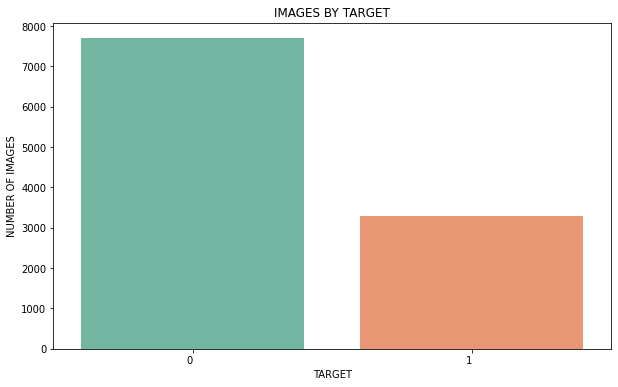

In [ ]:
plt.figure(figsize=(10, 6))
chart = sns.countplot(df4.target,
    x="target",
    palette='Set2'
)
chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=0, horizontalalignment='right')
plt.title("IMAGES BY TARGET")
plt.xlabel("TARGET")
plt.ylabel("NUMBER OF IMAGES")
plt.show()

In [ ]:
df4.to_csv('aug_sample.csv',index=False)